In [1]:
import numpy as np
import matplotlib.pyplot as plt
from metabayes import GibbsSampler, Prior

plt.style.use('ggplot')

# Creating synthetic data

In [2]:
num_experiments = 50
true_control_means = np.random.beta(100, 150, size=num_experiments)
true_effects = np.random.normal(0.01, 0.005, size=num_experiments)
true_treatment_means = true_control_means * (1 + true_effects)

num_trials = np.random.randint(10000, 50000, size=num_experiments)
control_successes = np.random.binomial(num_trials, true_control_means)
treatment_successes = np.random.binomial(num_trials, true_treatment_means)

# Creating the prior

In [3]:
prior = Prior()

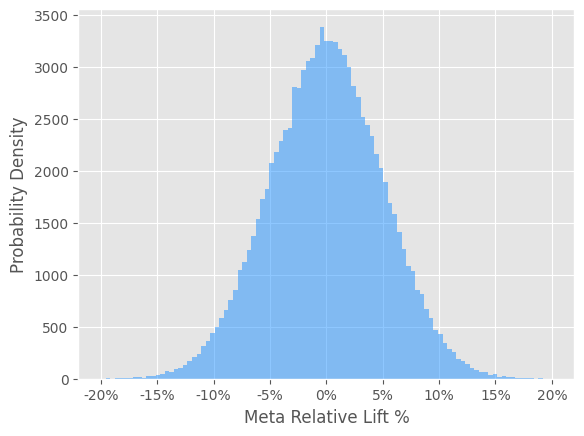

In [4]:
prior.plot_meta_effect_prior(color='dodgerblue', alpha=0.5)

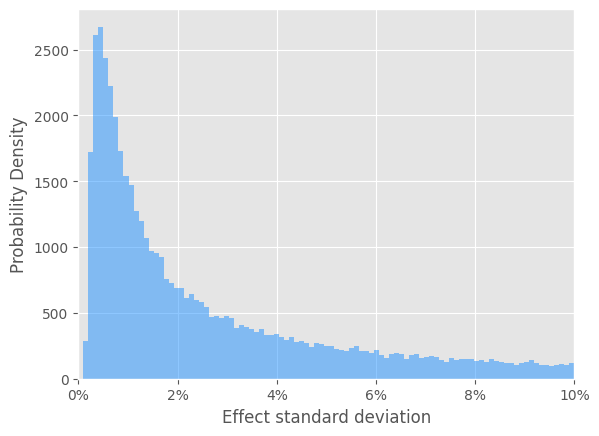

In [5]:
prior.plot_effect_sd_prior(color='dodgerblue', alpha=0.5)

# Running the model

In [6]:
gs = GibbsSampler.from_binary_counts(num_trials, control_successes, num_trials, treatment_successes, prior)
gs.run_model()

100%|████████████████████████████████████| 9999/9999 [00:00<00:00, 21221.04it/s]


# Plotting

In [7]:
def plot(uplift, ax, i, true_value):
    ax.flatten()[i].hist(uplift, bins=50, density=True, edgecolor='black', alpha=.8)
    ax.flatten()[i].set_title('exp {}'.format(i+1))
    ax.flatten()[i].axvline(x=true_value, color='black', label='true value')
    ax.flatten()[i].axvline(x=np.mean(uplift), color='red', linestyle='--', label='posterior mean')
    ax.flatten()[i].set_xlabel('% ch treatment')  
    ax.flatten()[i].set_ylabel('density') 
    
    
    conf = np.quantile(uplift, [.25, .75])
    ax.flatten()[i].axvspan(*conf, color='dodgerblue', alpha=.2, label='50% conf') 
    if i == 0:
        ax.flatten()[i].legend(bbox_to_anchor=(-.5, 1))

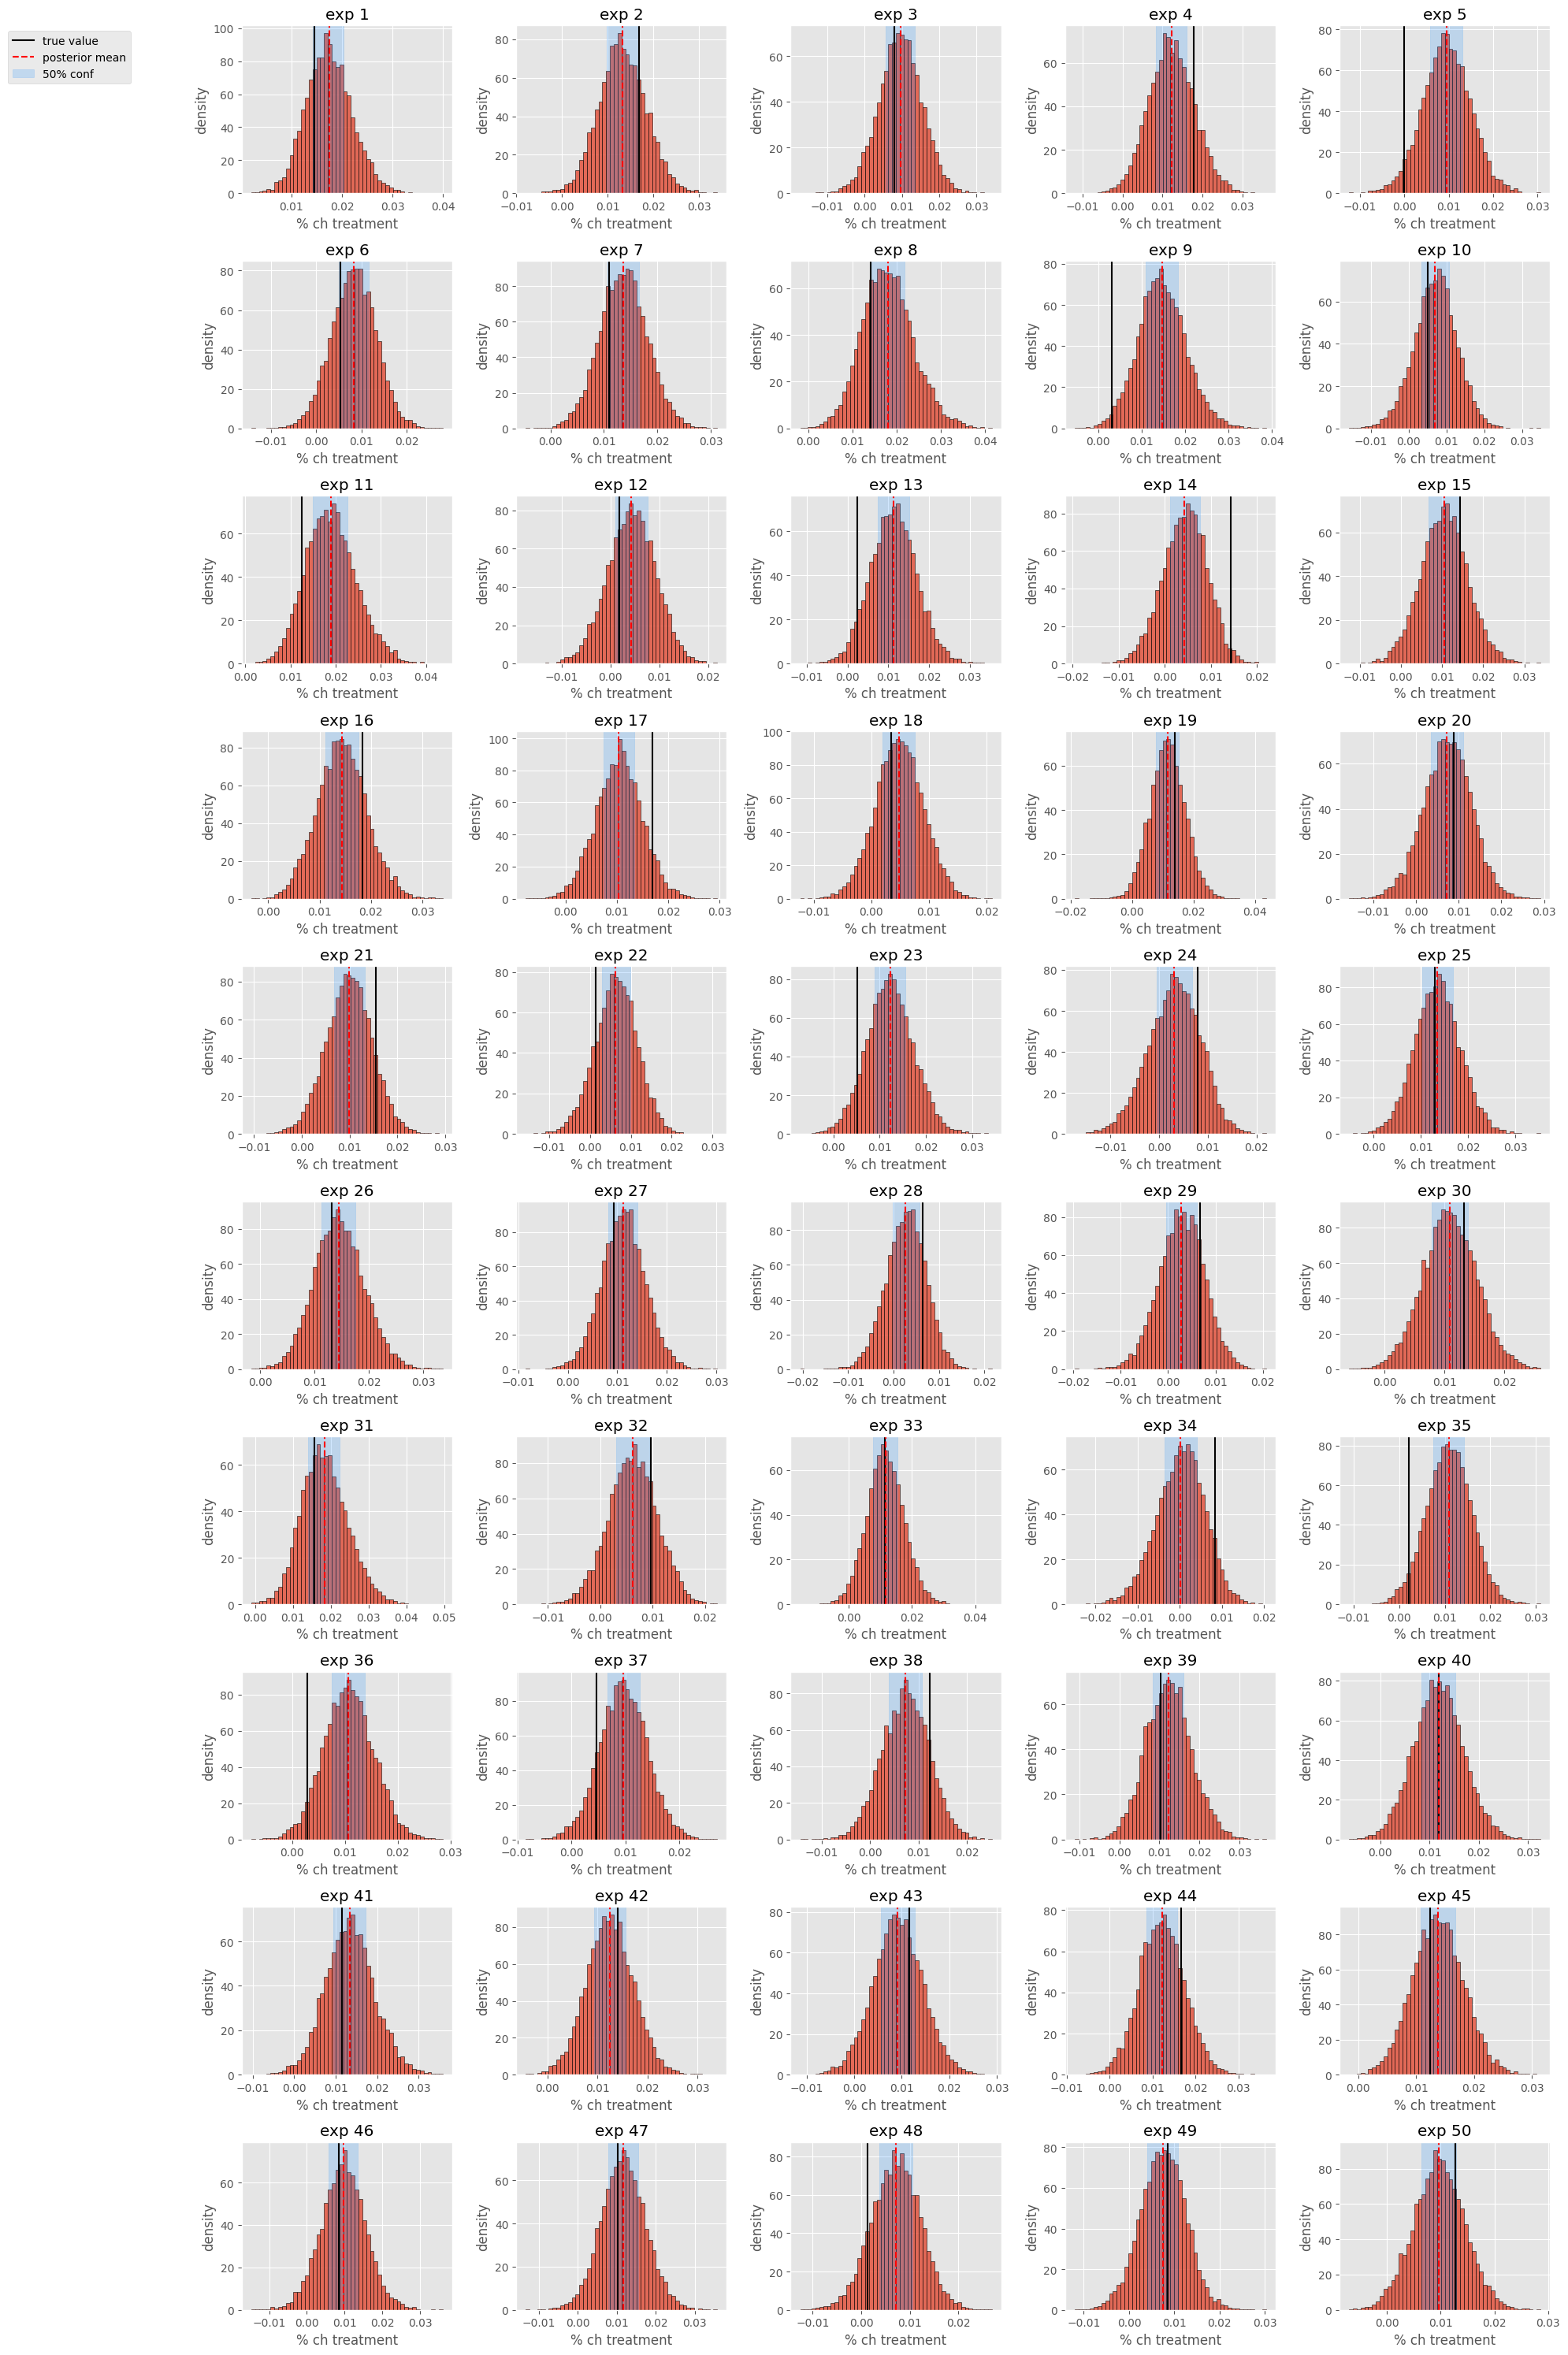

In [8]:
fig, ax = plt.subplots(ncols=5, nrows=10, figsize=(20, 30))
[plot(gs.traces['theta'][100:,i], ax, i, true_effects[i]) for i in range(num_experiments)]
fig.tight_layout()

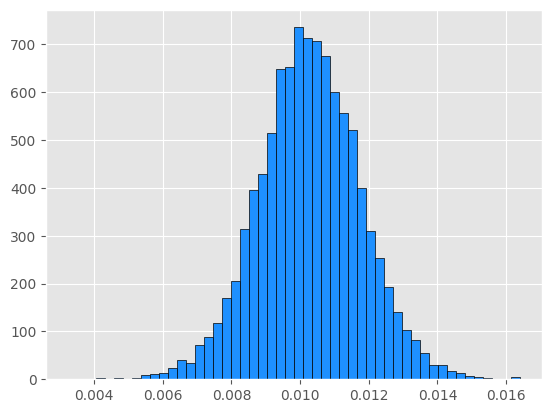

In [9]:
plt.hist(gs.traces['nu'][100:], bins=50, edgecolor='k', color='dodgerblue')
plt.show()

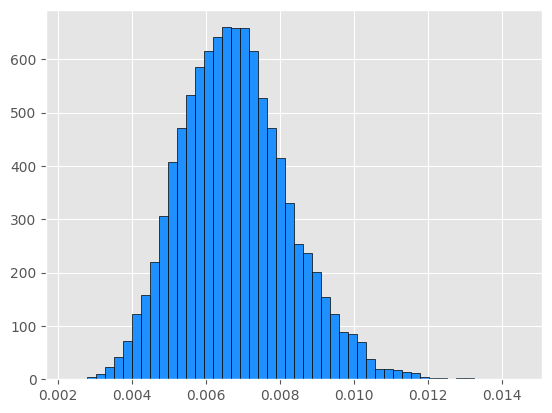

In [10]:
plt.hist(gs.traces['tau'][100:]**-.5, bins=50, edgecolor='k', color='dodgerblue')
plt.show()
